In [2]:
# Packages 
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import qmc
import glob
import h5py
import time
from datetime import timedelta

# We change the default level of the logger so that
# we can see what's happening with caching.
import sys, os
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c

# For interacting with the cache
from py21cmfast import cache_tools

# Cache for intermediate process
cache_direc = "/storage/home/hcoda1/3/bxia34/scratch/_cache"

if not os.path.exists(cache_direc):
    os.mkdir(cache_direc)

p21c.config['direc'] = cache_direc

str_pad_len = 80
str_pad_type = '-'

# Parallize
import multiprocessing
from multiprocessing import Pool
try:
    from mpi4py import MPI
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
except ImportError:
    rank = 0
    size =1

class Generate21cmImages():
    def __init__(self, num_images=9, **kwargs):
        """
        Generate dataset by 21cmFAST in parallel.
        Input: kwargs = {'param1': [min, max], 'param2': [min, max], ...}
        Output: hdf5 storing images and params.
        """
        self.kwargs = kwargs
        if rank == 0:
            print("kwargs:".center(int(str_pad_len/2)), "ranges:".center(int(str_pad_len/2)))
            for key in self.kwargs:
                print(f"{key}".center(int(str_pad_len/2))+f"{self.kwargs[key]}".center(int(str_pad_len/2)))
            # print(f"kwargs = {self.kwargs}".center(str_pad_len, str_pad_type))

        self.sample_normalized_params(dimension=len(self.kwargs), num_images=num_images)
        self.denormalize()
        self.define_default_params()

    def sample_normalized_params(self, dimension=2, num_images=4):
        """
        sample and scatter to other nodes
        """
        if rank == 0:
            sampler = qmc.LatinHypercube(d=dimension, strength=2)
            sample = sampler.random(n=num_images)
            send_data = sample[:int(sample.shape[0]//size * size),:]
            send_data = send_data.reshape(size, int(send_data.shape[0]/size), send_data.shape[1])
            print(f"Process {rank} scatters data (shape = {sample.shape}) to {size} nodes".center(str_pad_len,str_pad_type))
        else:
            send_data = None
        self.recv_data = comm.scatter(send_data, root=0)
        print(f"Process {rank} recvs data (shape = {self.recv_data.shape})".center(str_pad_len, str_pad_type))

    def denormalize(self):
        """
        denormalize data received, and return self.params_node which stores params for each node.
        """
        self.params_node = {}
        for i, kind in enumerate(self.kwargs):
            x = self.recv_data.T[i]
            k = self.kwargs[kind][1]-self.kwargs[kind][0]
            b = self.kwargs[kind][0]
            self.params_node[kind] = k*x + b

    def define_default_params(self):
        self.redshift = 11.93 
        self.user_params = {
            "HII_DIM":60, 
            "BOX_LEN":150, 
            "USE_INTERPOLATION_TABLE":True
            }
        self.cosmo_params = dict(
            SIGMA_8 = 0.810,
            hlittle = 0.677,
            OMm = 0.310,
            OMb = 0.0490,
            POWER_INDEX = 0.967,
            )
        self.astro_params = dict(
            ION_Tvir_MIN = 5,#params['ION_Tvir_MIN'],
            HII_EFF_FACTOR = 100,#params['HII_EFF_FACTOR'],
            )

    def update_params(self):
        params_list = ["user_params", "cosmo_params", "astro_params"]
        for params in params_list:
            for key in self.params_cpu:
                if key in self.__dict__[params]:
                    self.__dict__[params][key] = self.params_cpu[key]


    def generate_brightness_temp(self, params_node_value):
        # All parameters
        generate_brightness_temp_start = time.perf_counter()

        pid_cpu = multiprocessing.current_process().pid
        random_seed = np.random.randint(1,2**32) + pid_cpu

        self.params_cpu = {key: params_node_value[i] for (i, key) in enumerate(self.params_node.keys())}
        self.update_params()

        # Simulation
        coeval = p21c.run_coeval(
            redshift = self.redshift,
            user_params = self.user_params,
            cosmo_params = p21c.CosmoParams(self.cosmo_params),
            astro_params = p21c.AstroParams(self.astro_params),
            random_seed = random_seed
        )

        cache_pattern = os.path.join(cache_direc, f"*{coeval.random_seed}*")
        for filename in glob.glob(cache_pattern):
            # print(filename)
            os.remove(filename)

        generate_brightness_temp_end = time.perf_counter()
        time_elapsed = generate_brightness_temp_end - generate_brightness_temp_start
        print(f'cpu {pid_cpu} in {self.pid_node}, seed {random_seed}, {self.params_cpu}, cost {timedelta(seconds=time_elapsed)}')
        
        return coeval.brightness_temp

    def run(self, save_direc_name='images_params.h5'):
        self.pid_node = os.getpid()
        CPU_num = len(os.sched_getaffinity(self.pid_node))
        print(f"node {self.pid_node}: {CPU_num} CPUs are working on {np.shape(list(self.params_node.values()))[-1]} groups of params".center(str_pad_len,str_pad_type))

        # run p21c.run_coeval in parallel on multi-CPUs
        Pool_start = time.perf_counter()

        with Pool(CPU_num) as p:
            images_node = np.array(p.map(self.generate_brightness_temp, np.array(list(self.params_node.values())).T))

        Pool_end = time.perf_counter()
        time_elapsed = Pool_end - Pool_start

        print(f"images {images_node.shape} generated by node {self.pid_node} with {timedelta(seconds=time_elapsed)}".center(str_pad_len,str_pad_type))

        # save images, params as .h5 file
        self.save(images_node, params=np.array(list(self.params_node.values())).T, save_direc_name=save_direc_name)

        return images_node

    # Save as hdf5
    def save(self, images, params, save_direc_name):
        # if os.path.exists(save_direc_name):
        #     os.remove(save_direc_name)
        HII_DIM = images.shape[-1]
        with h5py.File(save_direc_name, 'a') as f:
            if 'images' not in f.keys():
                f.create_dataset(
                    'images', 
                    data=images, 
                    maxshape=(None, HII_DIM, HII_DIM, HII_DIM)
                )
                f.create_dataset(
                    'params',
                    data = params,
                    maxshape = (None, params.shape[-1]))
                # f.create_dataset(
                #     'random_seed',
                #     data=random_seed,
                #     maxshape=(None,1)
                # )
            else:
                # print(image.shape)
                new_size = f['images'].shape[0] + images.shape[0]
                f['images'].resize(new_size, axis=0)
                f['images'][-images.shape[0]:] = images
                f['params'].resize(new_size, axis=0)
                f['params'][-images.shape[0]:] = params
                # f['random_seed'].resize(new_size, axis=0)
                # f['random_seed'][-1] = random_seed

--------------------------------------------------------------------------

  Local host:   atl1-1-02-003-16-2
  Local device: mlx5_0
--------------------------------------------------------------------------


In [3]:
if __name__ == '__main__':
    kwargs = dict(
        ION_Tvir_MIN = [4,6],#params['ION_Tvir_MIN'],
        HII_EFF_FACTOR = [10, 250],#params['HII_EFF_FACTOR']
        )
    generator = Generate21cmImages(num_images=4, **kwargs)
    generator.run(save_direc_name="./callitaday.h5")

                kwargs:                                  ranges:                 
              ION_Tvir_MIN                               [4, 6]                 
             HII_EFF_FACTOR                            [10, 250]                
--------------Process 0 scatters data (shape = (4, 2)) to 1 nodes---------------
---------------------Process 0 recvs data (shape = (4, 2))----------------------
--------------node 94914: 4 CPUs are working on 4 groups of params--------------
cpu 95013 in 94914, seed 780922489, {'ION_Tvir_MIN': 4.156760451578173, 'HII_EFF_FACTOR': 213.6178629334318}, cost 0:00:09.274203
cpu 95014 in 94914, seed 780922490, {'ION_Tvir_MIN': 5.156760451578173, 'HII_EFF_FACTOR': 148.81125418938083}, cost 0:00:09.497471
cpu 95011 in 94914, seed 780922487, {'ION_Tvir_MIN': 4.696815524445265, 'HII_EFF_FACTOR': 93.61786293343178}, cost 0:00:09.699002
cpu 95012 in 94914, seed 780922488, {'ION_Tvir_MIN': 5.696815524445265, 'HII_EFF_FACTOR': 28.81125418938082}, cost 0:00:09

(4, 60, 60, 60)
(4, 2)


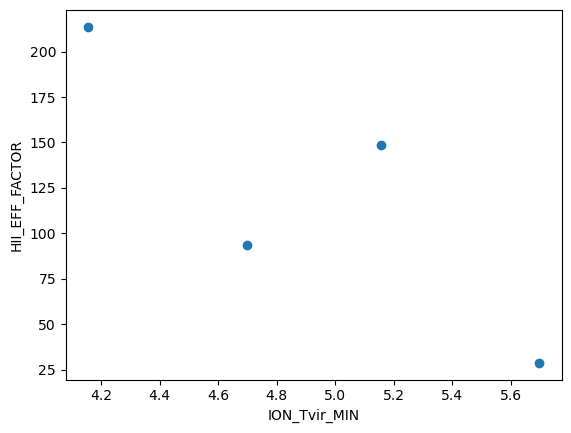

In [4]:
if __name__ == '__main__':
    # How to read images, params, and random_seed
    with h5py.File('callitaday.h5', 'a') as f:
        images = np.array(f['images'])
        labels = np.array(f['params'])
        # seed = np.array(f['random_seed'])
    print(images.shape)
    print(labels.shape)
    # print(seed)
    plt.scatter(labels.T[0], labels.T[1])
    plt.xlabel(list(kwargs.keys())[0])
    plt.ylabel(list(kwargs.keys())[1])

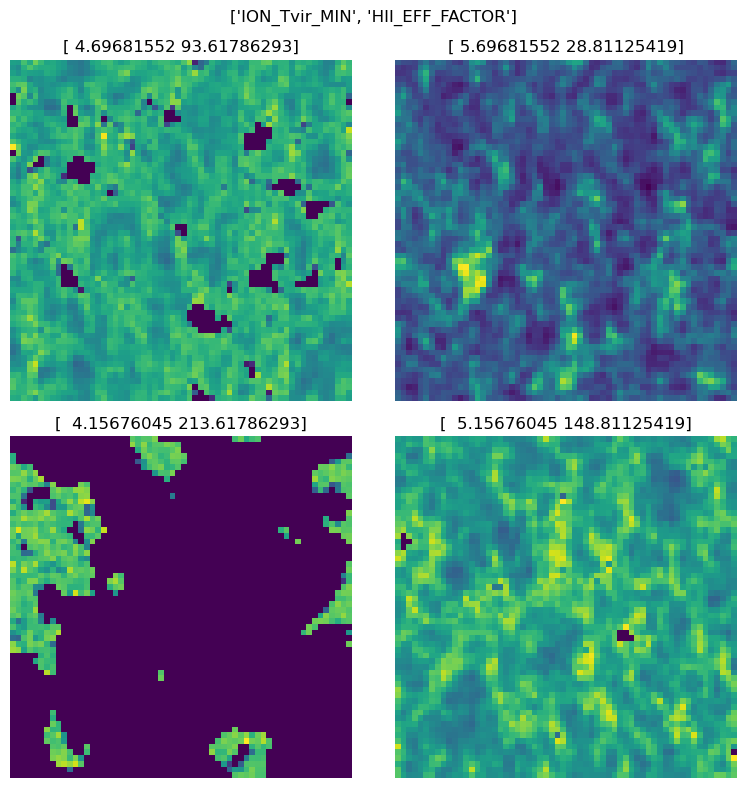

In [7]:
if __name__ == '__main__':
    fig, axes = plt.subplots(2,2, figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i][0])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.axis('off')
        ax.set_title(labels[i])
    # plt.margins(x=0, y=0)
    plt.suptitle(list(kwargs.keys()))
    plt.tight_layout(w_pad=0.2)
    # plt.close()